# Turn truth tables into degenerate graphs and visualize those graphs

### Imports

In [109]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import networkx as nx

from glob import glob
import os
import pickle

import pyrosetta
import pyrosetta.distributed.io as io
import pyrosetta.distributed.viewer as viewer
from pyrosetta.distributed.cluster import PyRosettaCluster
pyrosetta.init("-mute all")

from bokeh.io import output_file, output_notebook, show
from bokeh.plotting import figure, from_networkx
from bokeh.palettes import Spectral4
from bokeh.models.widgets.inputs import TextInput
from bokeh.models import (BoxZoomTool, Circle, HoverTool, MultiLine, Plot, Range1d, ResetTool, 
                          BoxSelectTool,EdgesAndLinkedNodes, NodesAndLinkedEdges, TapTool, CustomJS, 
                          Column, TextInput)

import ipywidgets as widgets
from ipywidgets import interact, SelectionSlider

PyRosetta-4 2021 [Rosetta PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python38.Release 2021.22+release.443f21dd132959f8866749933e59a911b7911995 2021-06-03T16:05:21] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


### Truth Tables / Gates

In [110]:
sns.set(
    context="talk",
    font_scale=1,  # make the font larger; default is pretty small
    style="ticks",  # make the background white with black lines
    palette="colorblind",  # a color palette that is colorblind friendly!
)

### $A \land B$ gate

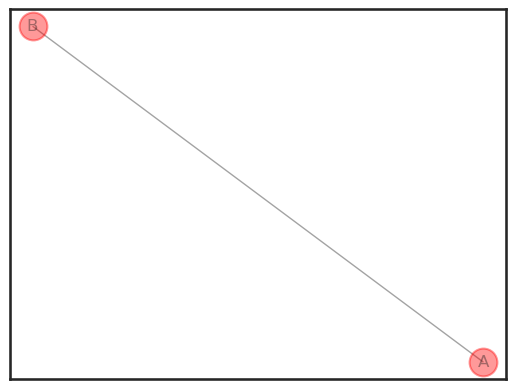

In [111]:
gate_states = [
    # A B
    [0, 0],
    [1, 0],
    [0, 1],
    [1, 1],
]

truth_vector = np.array([0, 0, 0, 1])


and_edges = [("A", "B"), ("B", "A")]
AND_gate = nx.Graph()
AND_gate.add_edges_from(and_edges)

options = {"node_color": "red", "node_size": 400, "alpha": 0.4}
nx.draw_networkx(AND_gate, with_labels=True, **options)
plt.show()

Aside: Below three-component gate graphs are only one of many possible degenerate graph solutions, work in progress. weights can be added as edge components to list as well

### $(A \land B) \lor C$ gate

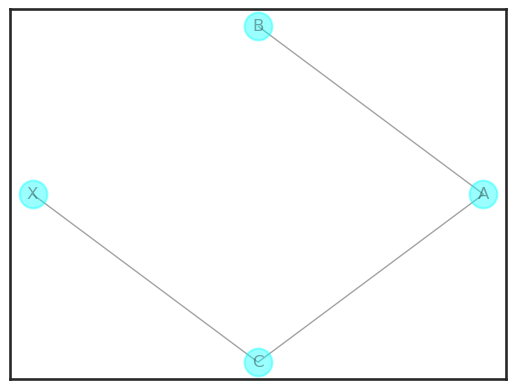

In [112]:
gate_states = [
    # A B C
    [0, 0, 0],
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1],
    [1, 1, 0],
    [1, 0, 1],
    [0, 1, 1],
    [1, 1, 1],
]

truth_vector = np.array([0, 0, 0, 1, 1, 1, 1, 1])

ANDOR_gate = nx.Graph()
ANDOR_gate.add_edges_from(and_edges + [("X", "C"), ("C", "X"), ("A", "C"), ("C", "A")])

options = {"node_color": "cyan", "node_size": 400, "alpha": 0.4}
nx.draw_networkx(
    ANDOR_gate, nx.circular_layout(ANDOR_gate), with_labels=True, **options
)
plt.show()

### all x all matrix
column 8 is wrong

In [113]:
allxall = np.load("allxall.npy")
# fix column 8 for now
allxall[:,7] = (allxall[:,7] * 0.10)
# add axis labels
xlabels = ["BW3_A_sm", "BW3_B_sm","BW5_A_sm","BW5_B_sm","IL8_A_sm","IL8_B_sm","IL9_A_sm","IL9_B_sm","IL14_A_sm","IL14_B_sm"]
ylabels = ["BW3_B_lg", "BW3_A_lg","BW5_B_lg","BW5_A_lg","IL8_B_lg","IL8_A_lg","IL9_B_lg","IL9_A_lg","IL14_B_lg","IL14_A_lg"]

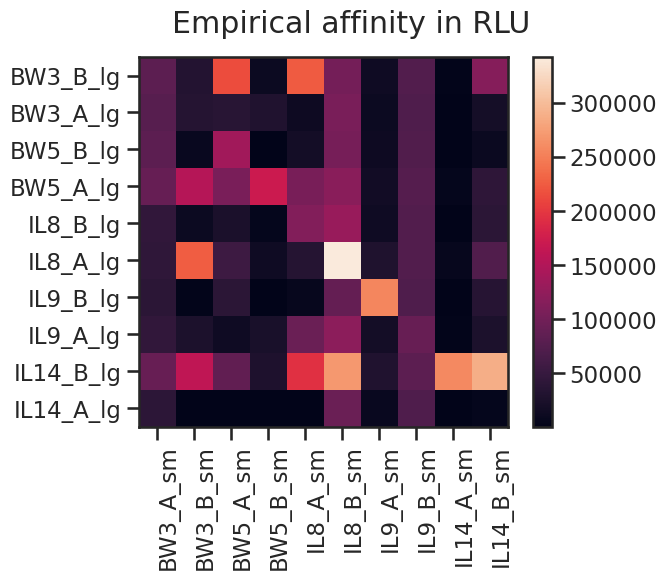

In [114]:
def plot_mat(matrix, xlabels, ylabels, title):
    fig, ax = plt.subplots()
    # We want to show all ticks...
    ax.set_xticks(np.arange(matrix.shape[0]))
    ax.set_yticks(np.arange(matrix.shape[1]))
    # ... and label them with the respective list entries
    ax.set_xticklabels(xlabels)
    ax.set_yticklabels(ylabels)
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
             rotation_mode="anchor")
    mat = ax.imshow(matrix)
    fig.suptitle(title)
    fig.colorbar(mappable=mat)
    plt.show()
    return


plot_mat(allxall, xlabels, ylabels, "Empirical affinity in RLU")

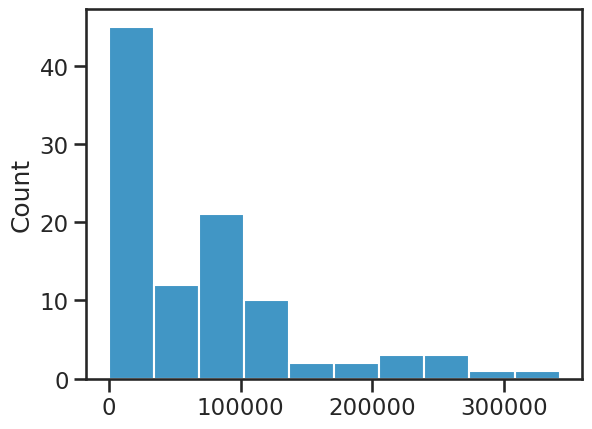

In [115]:
# get distribution of data
flat = allxall.flatten() #.reshape([1,100])
_ = sns.histplot(flat, bins="auto")
plt.show()

# Probably can threshold around 3.3e4

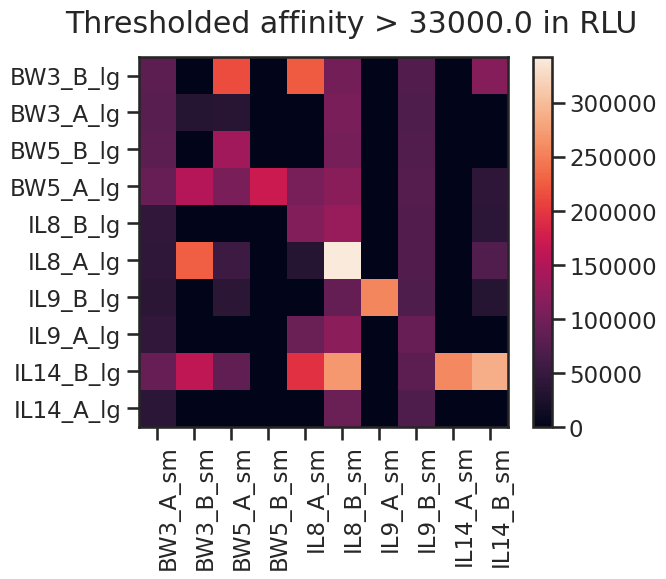

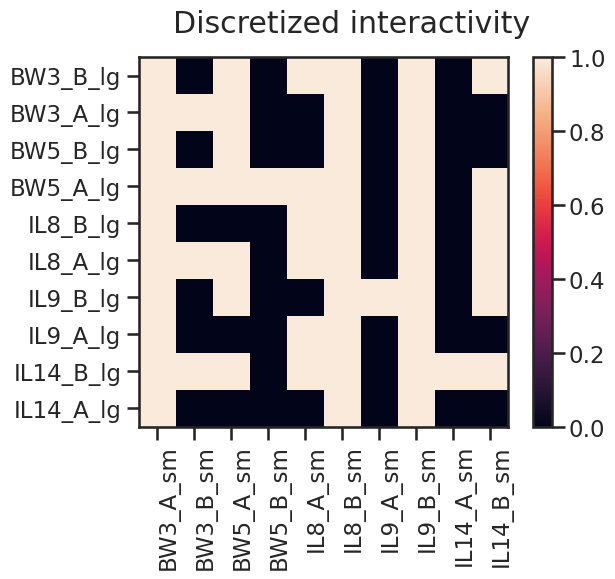

In [116]:
# if less than 3.3e4, 0
cutoff = 3.3e4
thresholded = allxall.copy()
thresholded[thresholded < cutoff] = 0
plot_mat(thresholded, xlabels, ylabels, f"Thresholded affinity > {cutoff} in RLU")

# discretize, if > 0, 1
discrete = thresholded.copy()
discrete[discrete > 0] = 1
plot_mat(discrete, xlabels, ylabels, f"Discretized interactivity")

### Try to build a graph by looping over the discretized matrix

In [117]:
plt.close()

# Instantiate networkx graph
G = nx.Graph()

# Parse data and append to graph objext
edges = []
for row, ylabel in enumerate(ylabels):
    for col, xlabel in enumerate(xlabels):
        if bool(discrete[row,col]):
            G.add_node(xlabel, chain=xlabel.split("_")[1], bit=xlabel.split("_")[-1])
            G.add_node(ylabel, chain=ylabel.split("_")[1], bit=ylabel.split("_")[-1])
            edges.append((xlabel, ylabel, {"weight": thresholded[row,col]}))
        else:
            pass

# Add edges to grah
G.add_edges_from(edges)

# Specify graph parameters
nodelist = G.nodes()
edgelist = weights.keys()
edgewidth=list(weights.values())
options = {"node_color": "red", "node_size": 400, "alpha": 0.4}
pos = nx.shell_layout(G)

In [118]:
def render_pdb(packed):
    view = viewer.init(packed, window_size=(800, 600))
    view.add(viewer.setStyle())
    view.add(viewer.setStyle(colorscheme="whiteCarbon", radius=0.0))
    view()

In [119]:
# TODO: 
def pdb_selection():
    print("Test")
    #selected_pdb = 
    
    #pdbs = glob(os.path.join(os.getcwd(), "pdbs", "*.pdb"))
    #packed_poses = {}
    
    #for pdb in pdbs:
        #packed_poses[pdb.split("/")[-1].replace(".pdb", "")] = io.pose_from_file(pdb)
    
    # dump all the pdbs in file
    #pickle.dump(packed_poses, open("poses.pickle", "wb" ))
    
    # only grab selected pdb
    #packed_poses = pickle.load(open("poses.pickle", "rb" ))

    #render_pdb(packed_poses)
    

In [120]:
# Let's try using bokeh's networkx integration to plot

# bin and discretize weights for plotting
weights_raw = nx.get_edge_attributes(G, "weight")
bins = np.linspace(min(weights_raw.values()), max(weights_raw.values()), 5)
weights = dict(zip(weights_raw.keys(), np.digitize(list(weights_raw.values()), bins=bins)))

# Add attributes for tooltip
nx.set_edge_attributes(G, weights, "weight")

bits = nx.get_node_attributes(G, "bit")
nx.set_node_attributes(G, bits, "bit")

chain = nx.get_node_attributes(G, "chain")
nx.set_node_attributes(G, chain, "chain")

# Define bokeh figure 
plot = figure(title="PPI Logic Network", tools="", toolbar_location=None)

# Style plot
plot.axis.visible = False
plot.xgrid.visible = False
plot.ygrid.visible = False

# Plot PPI network
graph = from_networkx(G, nx.circular_layout, scale=2, center=(0,0))

# Add interactivity with tooltip on hover
node_hover_tool = HoverTool(tooltips=[("index", "@index"), ("bit", "@bit"), ("chain", "@chain")])
plot.add_tools(TapTool(), BoxSelectTool(), node_hover_tool, ResetTool(), BoxZoomTool())

# Default plot
graph_renderer = from_networkx(G, nx.shell_layout, scale=1, center=(0, 0))
graph_renderer.node_renderer.glyph = Circle(size=15, fill_color=Spectral4[0])
graph_renderer.edge_renderer.glyph = MultiLine(line_alpha=0.8, line_width="weight")

# Fill node circle on hover and selection
graph_renderer.node_renderer.selection_glyph = Circle(size=15, fill_color=Spectral4[3])
graph_renderer.node_renderer.hover_glyph = Circle(size=15, fill_color=Spectral4[3])

# Fill/select edges on node hover/selection
graph_renderer.edge_renderer.selection_glyph = MultiLine(line_color=Spectral4[3], line_width="weight")
graph_renderer.edge_renderer.hover_glyph = MultiLine(line_color=Spectral4[3], line_width="weight")

# Link nodes to edges
graph_renderer.selection_policy = NodesAndLinkedEdges()


# Render and output plot in Jupyter Notebook
plot.renderers.append(graph_renderer)
output_notebook() 

info_index = TextInput(title = 'Selected Node Index:', value = '')
info_node = TextInput(title = 'Protein Node:', value = '')
esource = graph_renderer.node_renderer.data_source
code = """
        info_index.value = String(esource.selected.indices);
        info_node.value = String(esource.data['index'][info_index.value]);
        """

callback = CustomJS(args = dict(esource = esource, 
                                info_index = info_index, 
                                info_node = info_node), 
                    code = code, syncable=True)

### source.js_on_change('streaming', callback) ### --> useful for scoping maybe?
plot.select_one(TapTool).callback = callback
show(Column(plot, info_index, info_node))

Loading BokehJS ...

### What a mess. Still, it seems correct... 

In [34]:
nx.get_node_attributes(G, "bit")

{'BW3_A_sm': 'sm',
 'BW3_B_lg': 'lg',
 'BW5_A_sm': 'sm',
 'IL8_A_sm': 'sm',
 'IL8_B_sm': 'sm',
 'IL9_B_sm': 'sm',
 'IL14_B_sm': 'sm',
 'BW3_A_lg': 'lg',
 'BW3_B_sm': 'sm',
 'BW5_B_lg': 'lg',
 'BW5_A_lg': 'lg',
 'BW5_B_sm': 'sm',
 'IL8_B_lg': 'lg',
 'IL8_A_lg': 'lg',
 'IL9_B_lg': 'lg',
 'IL9_A_sm': 'sm',
 'IL9_A_lg': 'lg',
 'IL14_B_lg': 'lg',
 'IL14_A_sm': 'sm',
 'IL14_A_lg': 'lg'}

In [35]:
nx.get_node_attributes(G, "chain")

{'BW3_A_sm': 'A',
 'BW3_B_lg': 'B',
 'BW5_A_sm': 'A',
 'IL8_A_sm': 'A',
 'IL8_B_sm': 'B',
 'IL9_B_sm': 'B',
 'IL14_B_sm': 'B',
 'BW3_A_lg': 'A',
 'BW3_B_sm': 'B',
 'BW5_B_lg': 'B',
 'BW5_A_lg': 'A',
 'BW5_B_sm': 'B',
 'IL8_B_lg': 'B',
 'IL8_A_lg': 'A',
 'IL9_B_lg': 'B',
 'IL9_A_sm': 'A',
 'IL9_A_lg': 'A',
 'IL14_B_lg': 'B',
 'IL14_A_sm': 'A',
 'IL14_A_lg': 'A'}